In [1]:
%load_ext autoreload
%autoreload

In [2]:
import argparse
import os
import sys
import torchvision
from torch.backends import cudnn
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils import data
from torchvision import transforms
from torchvision import datasets
from PIL import Image

import numpy as np

from matplotlib import pyplot as plt

In [3]:
from utils import *
# import infogan2

In [4]:
# test_noise = noise_sample(10,10,1,1,1,'cpu')
params = {}
params['num_z']      = 62
params['dis_c_dim']  = 10
params['num_con_c']  =  2

params['batch_size'] = 100
params['epochs'] = 100

params['image_size']  = 28
params['num_workers'] = 1

#optimization params
params['lrD']   = 0.0002  # Learning rate for Discriminator
params['lrG']   = 0.001   # Learning rate for Generator
params['beta1'] = 0.5   # Momentum 1 in Adam
params['beta2'] = 0.999 # Momentum 2 in Adam

######################
test_noise = noise_sample(params['dis_c_dim'], 
                          params['num_con_c'], params['num_z'],
                          params['batch_size'],'cpu')

In [5]:
test_noise[0].size()

torch.Size([100, 74, 1, 1])

In [38]:
class Generator(nn.Module):
    def __init__(self, z_dim=62, cc_dim=2, dc_dim=10):
        super(Generator, self).__init__()
        i_dim = z_dim + cc_dim + dc_dim
        self.main = nn.Sequential(
          nn.ConvTranspose2d(i_dim, 1024, 1, 1, bias=False),
          nn.BatchNorm2d(1024),
          nn.ReLU(True),
          nn.ConvTranspose2d(1024,  128, 7, 1, bias=False),
          nn.BatchNorm2d(128),
          nn.ReLU(True),
          nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
          nn.BatchNorm2d(64),
          nn.ReLU(True),
          nn.ConvTranspose2d( 64,  1, 4, 2, 1, bias=False),
          nn.Sigmoid()
        )

    def forward(self, z):
        out = self.main(z)
        return out

class FrontEnd(nn.Module):
    def __init__(self):
        super(FrontEnd, self).__init__()
        
        self.main = nn.Sequential(
          nn.Conv2d(1, 64, 4, 2, 1),
          nn.LeakyReLU(0.1, inplace=True),
          nn.Conv2d(64, 128, 4, 2, 1, bias=False),
          nn.BatchNorm2d(128),
          nn.LeakyReLU(0.1, inplace=True),
          nn.Conv2d(128, 1024, 7, bias=False),
          nn.BatchNorm2d(1024),
          nn.LeakyReLU(0.1, inplace=True),
        )

    def forward(self, x):
        return self.main(x)
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.linear = nn.Sequential(
            nn.Conv2d(1024, 1, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        out = self.linear(x).view(-1, 1)
        return out #prob of being real

class Q(nn.Module):
    def __init__(self, cc_dim=2, dc_dim=10):
        super(Q, self).__init__()
        self.conv = nn.Conv2d(1024, 128, 1, bias=False)
        self.bn = nn.BatchNorm2d(128)
        self.lReLU = nn.LeakyReLU(0.1, inplace=True)
        
        self.conv_disc = nn.Conv2d(128, dc_dim, 1)
        self.conv_mu   = nn.Conv2d(128, cc_dim, 1)
        self.conv_var  = nn.Conv2d(128, cc_dim, 1)

    def forward(self, x):
        y = self.conv(x)
        
        disc_logits = self.conv_disc(y).squeeze()
        mu  = self.conv_mu(y).squeeze()
        var = self.conv_var(y).squeeze().exp()

        return disc_logits, mu, var

In [39]:
gen = Generator(params['num_z'], params['num_con_c'], params['dis_c_dim'])
dsc = Discriminator()
q   = Q(params['num_con_c'], params['dis_c_dim'])
fe  = FrontEnd()
# gen(test_noise[0]).size()
# fe(gen(test_noise[0])).size()
q(fe(gen(test_noise[0])))[0].size()
# dsc.front_end(gen(test_noise[0])).size()

torch.Size([100, 10])

In [24]:
#create dataset
transform = transforms.Compose([
#     transforms.Resize((params['image_size'], params['image_size'])),
    transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
dataset = datasets.MNIST('./MNIST', train=True, transform=transform, target_transform=None, download=True)

data_loader = data.DataLoader(dataset = dataset,
                              batch_size = params['batch_size'],
                              shuffle = True,
                              num_workers = params['num_workers'])

In [9]:
device = 'cpu'
init_weights = True
if torch.cuda.is_available():
    print('using cuda')
    gen.cuda()
    dsc.cuda()
    q.cuda()
    fe.cuda()
    device = 'cuda'
if init_weights:
    gen.apply(weights_init)
    dsc.apply(weights_init)
    q.apply(weights_init)
    fe.apply(weights_init)

using cuda


In [10]:
optim_d = optim.Adam([{'params':fe.parameters()}, {'params': dsc.parameters()}], 
                 lr=params['lrD'], betas=[params['beta1'], params['beta2']])
optim_g = optim.Adam([{'params':gen.parameters()}, {'params': q.parameters()}], 
                 lr=params['lrG'], betas=[params['beta1'], params['beta2']])

In [11]:
G_losses = []
D_losses = []

BCE = nn.BCELoss().to(device) #Binary Cross Entropy loss
CE  = nn.CrossEntropyLoss().to(device)
CQ  = NormalNLLLoss()

label = torch.FloatTensor(params['batch_size'], 1).to(device)
label = Variable(label, requires_grad=False)
for epoch in range(params['epochs']):
    for n_i, batch_data in enumerate(data_loader):
        ##########################
        # Optimize Discriminator #
        ##########################
        optim_d.zero_grad()
        ####### Real Data  #######
        real_im   = batch_data[0].to(device) # batch data also contains label info
        fe_out = fe(real_im)
        real_prob = dsc(fe_out)  # propability of classifying as real
        label.data.fill_(1)
        loss_real = BCE(real_prob, label) #
        loss_real.backward()
        ####### Fake Data  #######
        noise, idx = noise_sample(params['dis_c_dim'], 
                          params['num_con_c'], params['num_z'],
                          params['batch_size'], device)
        fake_im = gen(noise)
        fe_out2 = fe(fake_im.detach())
        fake_prob = dsc(fe_out2)  # propability of classifying as real
        label.data.fill_(0)
        loss_fake = BCE(fake_prob, label)
        loss_fake.backward()
        
        discriminator_loss = loss_real + loss_fake
        optim_d.step()
        ##########################
        #   Optimize Generator   #
        ##########################
        optim_g.zero_grad()
        
        fe_out = fe(fake_im)
        fake_prob = dsc(fe_out)  # propability of classifying as real
        label.fill_(1)
        reconstruct_loss = BCE(fake_prob, label)
        
        q_logits, q_mu, q_var = q(fe_out)
        target = torch.LongTensor(idx).to(device)
        # Calculating loss for discrete latent code.
        dis_loss = CE(q_logits, target)

        # Calculating loss for continuous latent code.
        con_c = noise[:, params['num_z'] + params['dis_c_dim'] : ].view(-1, params['num_con_c'])
        con_loss = CQ(con_c, q_mu, q_var) * 0.1

        # Generator Loss (Reconstruct, Discreate and Latent code)
        generator_loss = reconstruct_loss + dis_loss + con_loss
        generator_loss.backward()
        optim_g.step()

        ##########################
        #      Logging Part      #
        ##########################
        if (n_i) % 100 == 0 and n_i > 0:
            sys.stdout.write('Epoch/Iter:{0}/{1}, D_Loss: {2}, G_Loss: {3}\r'.format(
                epoch + 1, n_i, discriminator_loss.item(), generator_loss.item())
            )
            sys.stdout.flush()
    # Save the losses for plotting.
    G_losses.append(generator_loss.item())
    D_losses.append(discriminator_loss.item())
    print('')

Epoch/Iter:1/500, D_Loss: 1.1905925273895264, G_Loss: 1.0594171285629272
Epoch/Iter:2/500, D_Loss: 1.1465539932250977, G_Loss: 0.9331414699554443
Epoch/Iter:3/500, D_Loss: 1.2367300987243652, G_Loss: 0.8597397208213806
Epoch/Iter:4/500, D_Loss: 1.1566386222839355, G_Loss: 0.9146661758422852
Epoch/Iter:5/500, D_Loss: 1.2789788246154785, G_Loss: 0.9058943986892797
Epoch/Iter:6/500, D_Loss: 1.1264748573303223, G_Loss: 1.0086920261383057
Epoch/Iter:7/500, D_Loss: 1.2135241031646729, G_Loss: 0.9198848009109497
Epoch/Iter:8/500, D_Loss: 1.0980013608932495, G_Loss: 1.0975941419601449
Epoch/Iter:9/500, D_Loss: 1.13621985912323, G_Loss: 1.104158282279968384
Epoch/Iter:10/500, D_Loss: 1.1032354831695557, G_Loss: 0.9016455411911011
Epoch/Iter:11/500, D_Loss: 1.0142488479614258, G_Loss: 1.2914227247238164
Epoch/Iter:12/500, D_Loss: 1.002862572669983, G_Loss: 1.32566905021667486
Epoch/Iter:13/500, D_Loss: 0.9808954000473022, G_Loss: 1.2046728134155273
Epoch/Iter:14/500, D_Loss: 0.9071211814880371, 

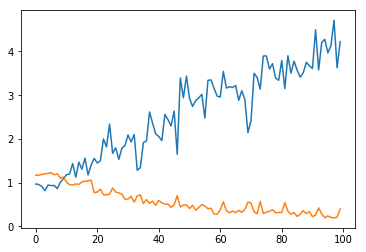

In [12]:
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.show()

In [13]:
torch.save(gen.state_dict(), 'mnist_info_gan_gen')
torch.save(dsc.state_dict(), 'mnist_info_gan_dsc')

In [14]:
idx = np.arange(10).repeat(10)
one_hot = np.zeros((100, 10))
one_hot[range(100), idx] = 1
    
fix_noise = torch.Tensor(100, 62).uniform_(-1, 1).cuda()
dis_c = torch.FloatTensor(100, 10).cuda()
dis_c.data.copy_(torch.Tensor(one_hot))

c = np.linspace(-1, 1, 10).reshape(1, -1)
c = np.repeat(c, 10, 0).reshape(-1, 1)
c1 = np.hstack([c, np.zeros_like(c)])
c2 = np.hstack([np.zeros_like(c), c])
    
con_c = torch.FloatTensor(100, 2).cuda()
con_c.data.copy_(torch.from_numpy(c1))
z = torch.cat([fix_noise, dis_c, con_c], 1).view(-1, 74, 1, 1)
x_save_c1 = gen(z)

con_c.data.copy_(torch.from_numpy(c2))
z = torch.cat([fix_noise, dis_c, con_c], 1).view(-1, 74, 1, 1)
x_save_c2 = gen(z)

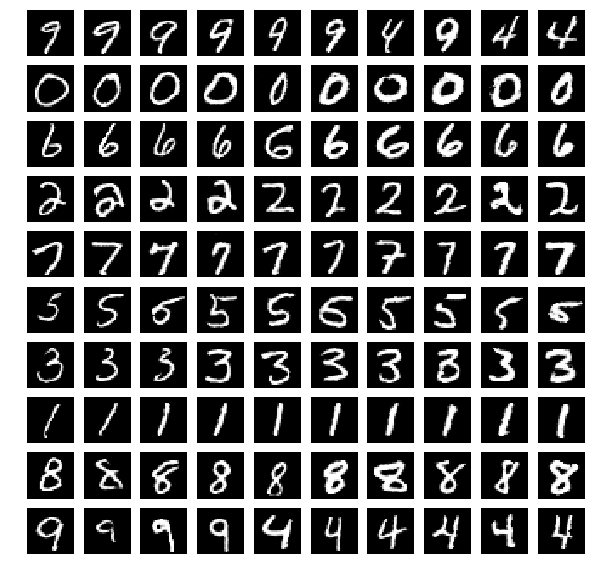

In [15]:
nimg = 10
f, ax = plt.subplots(10,10, figsize=(10,10))
for i in range(nimg):
    for j in range(nimg):
        ax[i][j].imshow(x_save_c1.data.cpu()[i*nimg + j][0], cmap='gray')
        ax[i][j].axis('off')

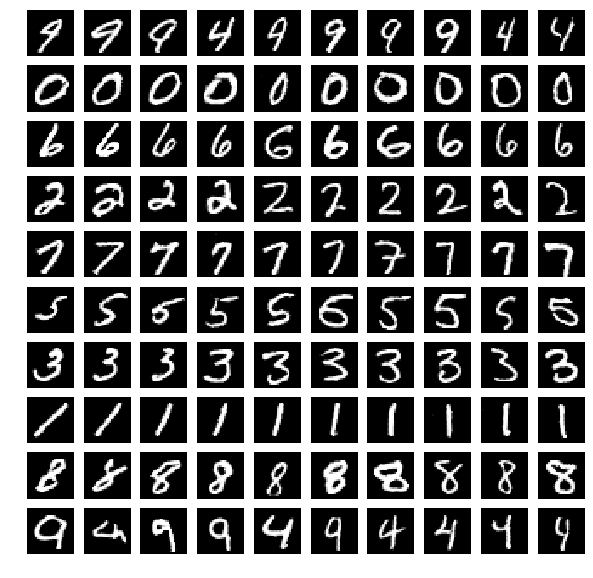

In [16]:
nimg = 10
f, ax = plt.subplots(10,10, figsize=(10,10))
for i in range(nimg):
    for j in range(nimg):
        ax[i][j].imshow(x_save_c2.data.cpu()[i*nimg + j][0], cmap='gray')
        ax[i][j].axis('off')